In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import  List, Union, Type, Callable

%matplotlib inline

BIG_SEED = 132 #random seed for later
score_metric = 'accuracy'
label_metric = 'Accuracy'

In [2]:
df = pd.read_csv('data.csv')

In [3]:
print(len(df))
df.head()

100


,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,2
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,2


In [4]:
#This way the rare class has value 1 (for the F-score)
df.Class = df.Class - 1

# Exercise 1

## Bayesian with LCB and EI

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter,\
                                        UniformIntegerHyperparameter

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO #Random Forest
from smac.facade.smac_bo_facade import SMAC4BO   #Bayesian
#from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer import acquisition

In [6]:
def optimizer(model_type :str, 
              config_space :Type[ConfigurationSpace],
              obj_function :Type[Callable],
              acquisition_type :str,
              n_iter :int = 10,
              init_points :int = 0,
              seed :int=None) -> Union[Type[SMAC4BO], Type[SMAC4HPO]]:
    """
    It is just a small wrapper to simplify and make more intuitive the SMAC optimization
    for ML algorithms for this assignment.
    PARAMETERS
    ----------
    @model_type       can be 'bo' for Bayesian optimization or 'rf' for RandomForest
    @config_space     an object of type ConfigSpace containing information
                      regarding the hyperparameters
    @obj_function     the objective function that needs to be minimized 
    @acquisition_type can be 'LCB' or 'EI' and indicated the type of acquisition function
                      to be used, if the value is different from 'LCB' or 'EI' it will
                      use the default acquisition function of SMAC
    @n_iter           number of iterations to do, defaults to 10 iterations
    @init_points      number of initial points, defaults to 0 initial points
    @seed             fix the seed for most of the randomness to have reproducible results
    
    RETURN
    ------
    either an optimized SMAC4BO object if 'bo' model_type was chosen or an
    optimized SMAC4HPO object if 'rf' model_type was chosen
    """
    #create the scenario required by SMAC optimizers
    scenario = Scenario(scenario={"run_obj": "quality",    # we optimize quality
                                  "runcount-limit": n_iter,# number iterations
                                  "cs": config_space,      # configuration space
                                  "output_dir": "logs",    # create a log folder named 'logs'
                                  "deterministic": "true"})
    
    #create init_points random points, fixing the seed if necessary
    cs.seed(seed)
    init = cs.sample_configuration(init_points)
    cs.seed(None) #remove the seed from configuration space
    
    #chose the acquisition function
    if acquisition_type == 'LCB':
        print('Using LCB acquisition Function')
        _acquistion = acquisition.LCB
    elif acquisition_type == 'EI':
        print('Using EI acquisition Function')
        _acquistion = acquisition.EI
    else:
        print('Using SMAC Default acquisition Function')
        _acquistion = None
        
    #chose and optimize the SMAC model
    if model_type == 'bo':
        #use SMAC4BO
        smac = SMAC4BO(scenario=scenario, tae_runner=obj_function, 
                       rng=np.random.RandomState(seed),
                       initial_design=None, 
                       initial_design_kwargs={'max_config_fracs':init_points/n_iter},
                       initial_configurations=init, 
                       acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    if model_type == 'rf':
        #use SMAC4HPO
        smac = SMAC4HPO(scenario=scenario, tae_runner=obj_function, 
                        rng=np.random.RandomState(seed),
                        initial_design=None, 
                        initial_design_kwargs={'max_config_fracs':init_points/n_iter},
                        initial_configurations=init, 
                        acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    #in case model_type was neither bo nor rf
    raise ValueError("Model type can only 'bo' or 'rf'")

In [7]:
#SMAC needs a Configuration Space where it will search for the hyperparameters
cs = ConfigurationSpace()

#define the domain of each hyperparameter
lr = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9)

#add the hyperparameters to the configuration space
cs.add_hyperparameters([lr, momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

In [8]:
def MLP_score_1(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    #rseed = int(conf['momentum']*conf['learning_rate_init']*5000)
    rseed = BIG_SEED
    MLPclf = MLPClassifier(hidden_layer_sizes=(4,2,), momentum = conf['momentum'],
                          learning_rate_init = conf['learning_rate_init'],
                          random_state=rseed)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    return 1 - np.mean(score)  # it needs to Minimize it!

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Using LCB acquisition Function
0.08028135089132196 0.38552141981754795 0.8623232323232324
0.04430300876374074 0.8696975470069911 0.8605050505050507
0.0845773877536592 0.3849918837749665 0.8603030303030306
0.0803514512536536 0.7548643234302469 0.8632323232323234


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1368) is better than incumbent (0.1377) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.08028135089132196 -> 0.0803514512536536
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.38552141981754795 -> 0.7548643234302469


0.08214374064161822 0.8241504085662323 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1277) is better than incumbent (0.1368) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0803514512536536 -> 0.08214374064161822
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7548643234302469 -> 0.8241504085662323
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.07928865274824823 0.825471177905083 0.8623232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08294309846333317 0.8230020534886903 0.8814141414141415


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1186) is better than incumbent (0.1277) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.08214374064161822 -> 0.08294309846333317
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8241504085662323 -> 0.8230020534886903
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.08330953185501089 0.8223631865469047 0.8714141414141416


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.08271352110058103 0.6571041027163039 0.8623232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.08279158643751475 0.8198501671499885 0.8714141414141416


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.083074412857059 0.8234959885174952 0.8814141414141415


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.08169509016516283 0.8176566052270614 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.017982697737400338 0.8231385631975681 0.7859595959595961


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.08515105180238035 0.8527742514113329 0.8614141414141414


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.07484972568376207 0.8105187196830494 0.8632323232323234


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.01372897017084241 0.38855265839210784 0.8532323232323232


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.09977663035881293 0.8329162991655239 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.09830551707577878 0.8373989093456015 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.09690991556968466 0.8293380375287133 0.8614141414141414


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.0990179168779944 0.8772598106949682 0.8814141414141415


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.09582347979125913 0.8749908437911846 0.8814141414141415


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.09505790588007984 0.8896578446228168 0.8814141414141415


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.09543669087134767 0.5010851563471104 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.0885358893330234 0.4310776346696129 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186


0.09921617843951103 0.10001568237426325 0.8814141414141415


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 3
INFO:smac.stats.stats.Stats:#Target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Configurations: 25
INFO:smac.stats.stats.Stats:Used wallclock time: 82.82 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 17.79 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  learning_rate_init, Value: 0.08294309846333317
  momentum, Value: 0.8230020534886903

INFO:smac.facade.smac_bo_facade.SMAC4BO:Estimated cost of incumbent: 0.118586


Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.08294309846333317
  momentum, Value: 0.8230020534886903



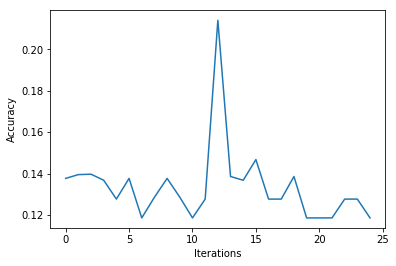

In [9]:
#Use bo and LCB
smac_LCB = optimizer('bo', cs, obj_function=MLP_score_1, 
                     acquisition_type='LCB', n_iter=25, 
                     init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(smac_LCB.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Using EI acquisition Function
0.08028135089132196 0.38552141981754795 0.8623232323232324
0.04430300876374074 0.8696975470069911 0.8605050505050507
0.0845773877536592 0.3849918837749665 0.8603030303030306
0.0803514512536536 0.7548643234302469 0.8632323232323234


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1368) is better than incumbent (0.1377) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.08028135089132196 -> 0.0803514512536536
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.38552141981754795 -> 0.7548643234302469


0.08214374064161822 0.8241504085662323 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1277) is better than incumbent (0.1368) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0803514512536536 -> 0.08214374064161822
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7548643234302469 -> 0.8241504085662323
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08257652196029153 0.8232996377921511 0.8714141414141416


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.0814106280134843 0.8262065778193011 0.8632323232323234


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08233388825032034 0.8238878244918617 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.09248662663184126 0.8239853277672542 0.8423232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08222985792333878 0.8092760786879524 0.8541414141414142


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.0779682250644476 0.8235653489025919 0.8623232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08150938634062703 0.8215086926496763 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08176440372728849 0.8196826887097818 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08028058048131435 0.8185719177475147 0.8623232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.09774721728224939 0.10681114186391244 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08187951943178857 0.821768772634006 0.8632323232323234


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08159610945303175 0.8197993553125666 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08112253994407717 0.8214047861996506 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08134062783186244 0.8208194771379707 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08255256030566152 0.8251268249065625 0.8623232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08104597800118746 0.8228941473145269 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.09797004831774116 0.10807798095907088 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.09727998761633595 0.10795113527609108 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.09759210589872637 0.10934967904957468 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277


0.08184665737541585 0.8179957135877721 0.8723232323232324


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1277
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 2
INFO:smac.stats.stats.Stats:#Target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Configurations: 25
INFO:smac.stats.stats.Stats:Used wallclock time: 89.99 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 16.83 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  learning_rate_init, Value: 0.08214374064161822
  momentum, Value: 0.8241504085662323

INFO:smac.facade.smac_bo_facade.SMAC4BO:Estimated cost of incumbent: 0.127677


Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.08214374064161822
  momentum, Value: 0.8241504085662323



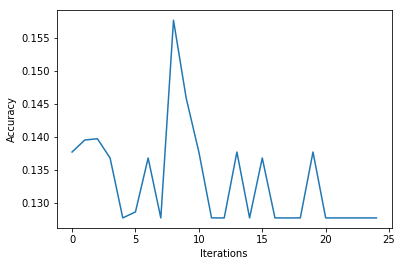

In [10]:
#Use bo and EI
smac_EI = optimizer('bo', cs, obj_function=MLP_score_1, 
                    acquisition_type='EI', n_iter=25, 
                    init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(smac_EI.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

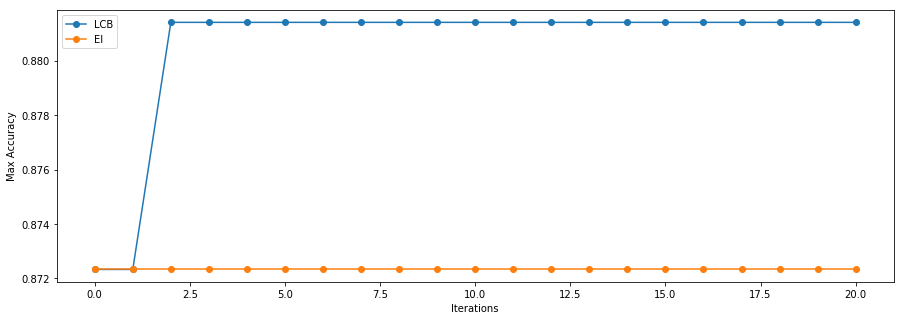

In [11]:
#Compare the two models removing the initial 5 points keeping only the best of them.
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_LCB.get_X_y()[1])[4:], 'o-') #0,1,2,3,4 sono i punti iniziali
plt.plot(1-np.minimum.accumulate(smac_EI.get_X_y()[1])[4:], 'o-')
plt.legend(['LCB','EI'])
plt.ylabel('Max '+label_metric)
plt.xlabel('Iterations')
plt.show()

## Grid and Randomized Search

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time

In [13]:
#create the configuration grid with 5 element for each hyperparameter
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5)}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1) #n_jobs=-1 parallelize the computation

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'learning_rate_init': 0.1, 'momentum': 0.1}
Training Completed in 7.809s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Max Score 0.87


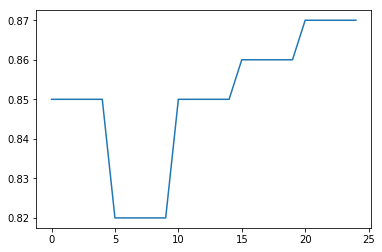

In [14]:
print("Max Score", np.max(MLP_GS.cv_results_['mean_test_score']))
plt.plot(MLP_GS.cv_results_['mean_test_score'])
plt.show()

In [15]:
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9)}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=25, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.3938775510204082, 'learning_rate_init': 0.09081632653061225}
Training Completed in 8.058s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Max Score 0.87


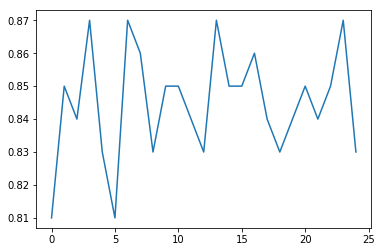

In [16]:
print("Max Score", np.max(MLP_RS.cv_results_['mean_test_score']))
plt.plot(MLP_RS.cv_results_['mean_test_score'])
plt.show()

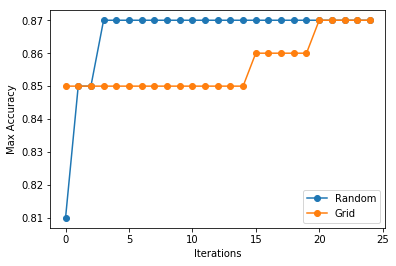

In [17]:
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Max '+label_metric)
plt.xlabel('Iterations')
plt.show()

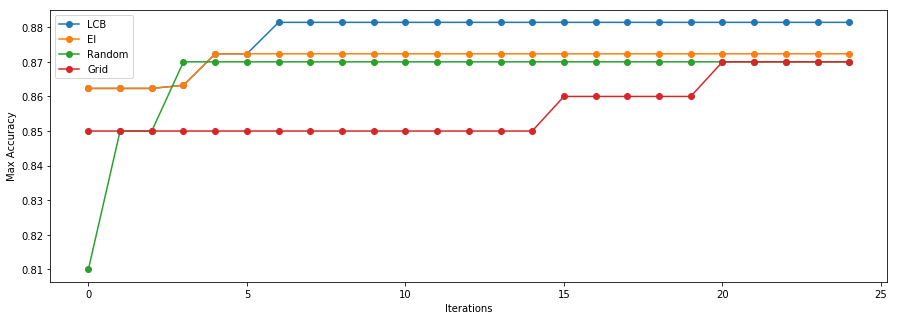

In [18]:
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_LCB.get_X_y()[1]), 'o-')
plt.plot(1-np.minimum.accumulate(smac_EI.get_X_y()[1]), 'o-')
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['LCB','EI','Random','Grid'])
plt.ylabel('Max '+label_metric)
plt.xlabel('Iterations')
plt.show()

# Exercise 2

In [19]:
hidden1 = UniformIntegerHyperparameter('h1',1,5)
hidden2 = UniformIntegerHyperparameter('h2',1,5)

cs.add_hyperparameters([hidden1, hidden2])

[h1, Type: UniformInteger, Range: [1, 5], Default: 3,
 h2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [20]:
def MLP_score_2(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    #rseed = int(conf['momentum']*conf['learning_rate_init']*5000)
    rseed = BIG_SEED
    MLPclf = MLPClassifier(hidden_layer_sizes=(conf['h1'],conf['h2'],), 
                           momentum = conf['momentum'],
                           learning_rate_init = conf['learning_rate_init'],
                           random_state=rseed)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    #print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    return 1 - np.mean(score)  # it needs to Minimize it!

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Using EI acquisition Function


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1186) is better than incumbent (0.1559) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 4 -> 2
INFO:smac.intensification.intensification.Intensifier:  h2 : 2 -> 5
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.013848694426312692 -> 0.01145707336828471
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.4268122699715259 -> 0.3604269932856067
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:sma

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  h1, Value: 3
  h2, Value: 3
  learning_rate_init, Value: 0.06572782040024759
  momentum, Value: 0.4365410956845236



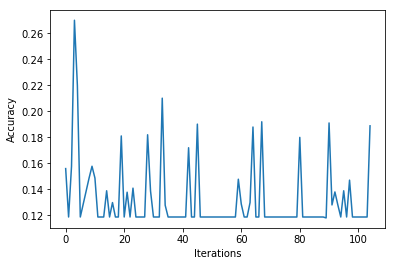

In [21]:
#Use rf and EI
smac_rf_EI = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='EI', n_iter=105, 
                    init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(smac_rf_EI.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Using LCB acquisition Function


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1186) is better than incumbent (0.1559) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 4 -> 2
INFO:smac.intensification.intensification.Intensifier:  h2 : 2 -> 5
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.013848694426312692 -> 0.01145707336828471
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.4268122699715259 -> 0.3604269932856067
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:sma

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1088
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  h1, Value: 3
  h2, Value: 3
  learning_rate_init, Value: 0.07229987842069119
  momentum, Value: 0.49906480155563326



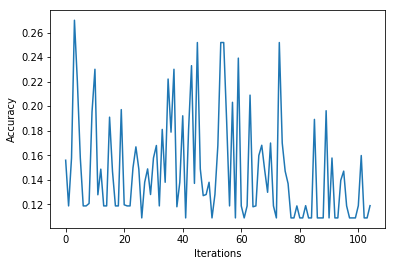

In [22]:
#Use rf and LCB
smac_rf_LCB = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='LCB', n_iter=105, 
                    init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(smac_rf_LCB.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

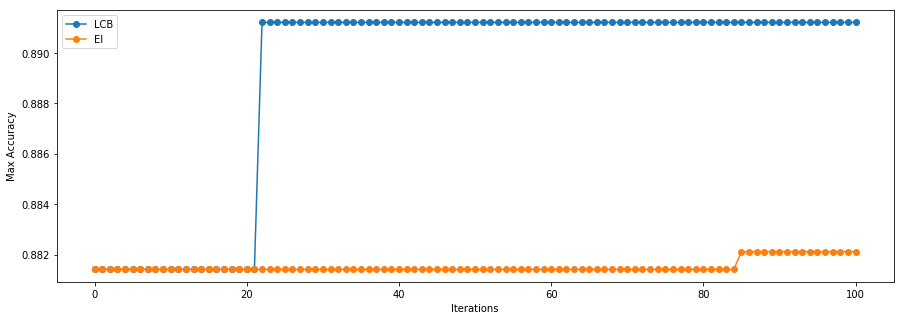

In [23]:
#Compare the two models removing the initial 5 points keeping only the best of them.
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1])[4:], 'o-') #0,1,2,3,4 sono i punti iniziali
plt.plot(1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1])[4:], 'o-')
plt.legend(['LCB','EI'])
plt.ylabel('Max '+label_metric)
plt.xlabel('Iterations')
plt.show()

## Random and Grid Search

In [24]:
#create the configuration grid with 5 element for each hyperparameter
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5),
             'hidden_layer_sizes':[(1,1), (1,5), (5,1), (5,5)]}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1) #n_jobs=-1 parallelize the computation

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_, "-> score", MLP_GS.best_score_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'hidden_layer_sizes': (1, 1), 'learning_rate_init': 0.01, 'momentum': 0.1} -> score 0.88
Training Completed in 18.120s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
hidden =[(i, j) for i in range(1,6) for j in range(1,6)]        
        
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9),
              'hidden_layer_sizes':hidden}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=100, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_, "-> score", MLP_RS.best_score_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.9, 'learning_rate_init': 0.017346938775510204, 'hidden_layer_sizes': (5, 2)} -> score 0.89
Training Completed in 20.044s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


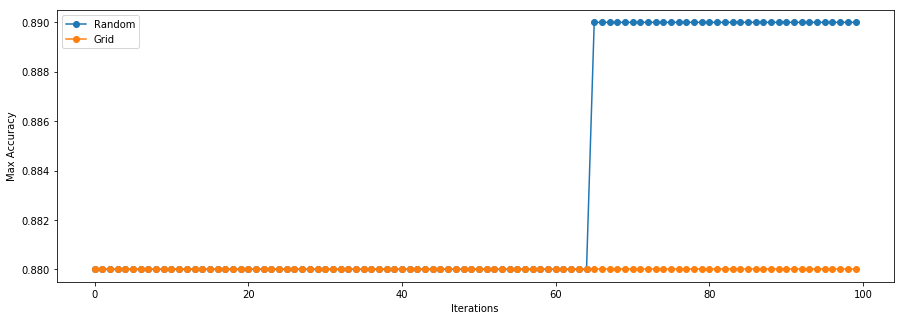

In [26]:
plt.figure(figsize=(15,5))
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Max '+label_metric)
plt.xlabel('Iterations')
plt.show()

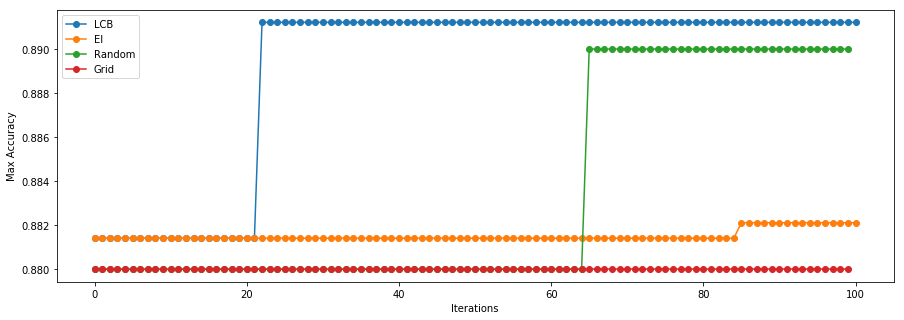

In [27]:
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1])[4:], 'o-')
plt.plot(1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1])[4:], 'o-')
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['LCB','EI','Random','Grid'])
plt.ylabel('Max '+label_metric)
plt.xlabel('Iterations')
plt.show()